### Qcodes example notebook for Alazar card ATS9360 and acq controllers

In [1]:
import qcodes as qc
import qcodes.instrument.parameter as parameter
import qcodes.instrument_drivers.AlazarTech.ATS9360 as ATSdriver
import qcodes.instrument_drivers.AlazarTech.basic_controller as basic_aqc_contr
import qcodes.instrument_drivers.AlazarTech.samp_controller as samp_acq_contr
import qcodes.instrument_drivers.AlazarTech.ave_controller_test as ave_acq_controller
import qcodes.instrument_drivers.AlazarTech.rec_controller_test as record_acq_controller

import logging
# logging.basicConfig(filename='example.log',level=logging.INFO)

qc.halt_bg()

No loop running


NB: See ATS9360 example notebook for general commands 

In [2]:
# Create the ATS9360 instrument
alazar = ATSdriver.AlazarTech_ATS9360(name='Alazar')
# Print all information about this Alazar card
alazar.get_idn()

{'CPLD_version': '25.16',
 'SDK_version': '5.9.25',
 'asopc_type': '1712554848',
 'bits_per_sample': 12,
 'driver_version': '5.9.25',
 'firmware': None,
 'latest_cal_date': '13-11-15',
 'max_samples': 4294967294,
 'memory_size': '4294967294',
 'model': 'ATS9360',
 'pcie_link_speed': '0.5GB/s',
 'pcie_link_width': '8',
 'serial': '970344',
 'vendor': 'AlazarTech'}

In [3]:
# Configure all settings in the Alazar card
alazar.config(clock_source='EXTERNAL_CLOCK_10MHz_REF',
              sample_rate=500000000,
              clock_edge='CLOCK_EDGE_RISING',
              decimation=1,
              coupling=['DC','DC'],
              channel_range=[.4,.4],
              impedance=[50,50],
              trigger_operation='TRIG_ENGINE_OP_J',
              trigger_engine1='TRIG_ENGINE_J',
              trigger_source1='EXTERNAL',
              trigger_slope1='TRIG_SLOPE_POSITIVE',
              trigger_level1=140,
              trigger_engine2='TRIG_ENGINE_K',
              trigger_source2='DISABLE',
              trigger_slope2='TRIG_SLOPE_POSITIVE',
              trigger_level2=128,
              external_trigger_coupling='DC',
              external_trigger_range='ETR_2V5',
              trigger_delay=0,
              timeout_ticks=0,
              aux_io_mode='AUX_IN_AUXILIARY', # AUX_IN_TRIGGER_ENABLE for seq mode on
              aux_io_param='NONE' # TRIG_SLOPE_POSITIVE for seq mode on
             )

### Basic Acquisition

Pulls the raw data the alazar acquires averaged over number of records buffers.

In [4]:
# Create the acquisition controller which will take care of the data handling and tell it which 
# alazar instrument to talk to.
basic_acq_controller = basic_aqc_contr.Basic_Acquisition_Controller(name='basic_acq_controller', 
                                                                    alazar_name='Alazar')

In [5]:
# Configure settings in the controller to be used in an acquisition
# nb this must be done before the first acquisition 
basic_acq_controller.update_acquisition_kwargs(samples_per_record=128*11,
                                              records_per_buffer=100,
                                              buffers_per_acquisition=1,
                                              allocated_buffers=1
                                              )

In [6]:
# Pull data from the card by calling get of the controllers acquisition parameter
data1 = basic_acq_controller.acquisition()
print(data1)

(array([-0.00903541, -0.00757021,  0.0002442 , ...,  0.2014652 ,
        0.197558  ,  0.1965812 ]), array([-0.0002442,  0.0007326, -0.0002442, ...,  0.0007326, -0.0002442,
        0.0007326]))


In [11]:
# Do this in as qcodes measurement (ie the same but makes a data set)
data2 = qc.Measure(basic_acq_controller.acquisition).run()
plot = qc.MatPlot(data2.basic_acq_controller_A)

DataSet:
   mode     = DataMode.LOCAL
   location = '2017-01-23/18-17-17'
   <Type>   | <array_id>             | <array.name> | <array.shape>
   Measured | index0                 | index0       | (1408,)
   Measured | basic_acq_controller_A | A            | (1408,)
   Measured | basic_acq_controller_B | B            | (1408,)
acquired at 2017-01-23 18:17:18


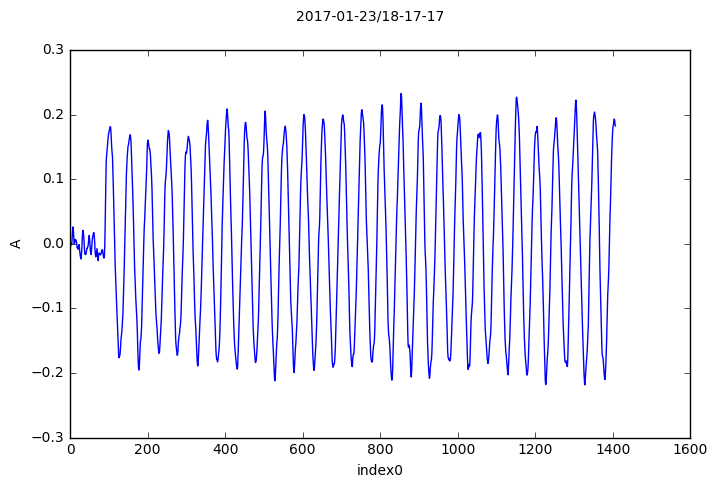

In [17]:
plot.fig


In [10]:
# Do this in as qcodes measurement (ie the same but makes a data set)
#data3 = qc.Measure(basic_acq_controller.acquisition).run()
plot = qc.QtPlot(data2.basic_acq_controller_B)

gaierror: [Errno 11004] getaddrinfo failed

In [ ]:
# Finally show that this instrument also works within a loop
dummy = parameter.ManualParameter(name="dummy")

data3 = qc.Loop(dummy[0:5:1]).each(basic_acq_controller.acquisition).run(name='AlazarTest')
qc.QtPlot(data3.basic_acq_controller_A)

### Samples Acquisition

This is the same as above except that it does some demodulation at the freqiencies specified

In [19]:
# Create the acquisition controller which will take care of the data handling and tell it which 
# alazar instrument to talk to and does the demodulation and signal processing
samp_acq_controller = samp_acq_contr.HD_Samples_Controller(name='samp_acq_controller', 
                                                           alazar_name='Alazar',
                                                           demod_length=2)

In [25]:
# set the two demodulation frequencies
samp_acq_controller.demod_freq_0(1e6)
samp_acq_controller.demod_freq_1(2e6)

# set integration time and delay (nb this replaces need to set samples_per record)
# if int_delay is unset it will default to a value corresponding to the about needed for the filter to work well
samp_acq_controller.int_time(10e-6)
samp_acq_controller.int_delay(0)

In [40]:
# to_default() can be used to reset int_delay to recommended filter value and int_time to use the maximum remaining time
# with the current number of samples_per_record
samp_acq_controller.int_time.to_default()
samp_acq_controller.int_delay.to_default()

In [22]:
# update_acquisition_kwargs now should not be used with samples_per_record but instead just for changing averaging values
samp_acq_controller.update_acquisition_kwargs(
                 records_per_buffer=100,
                 buffers_per_acquisition=100,
                 allocated_buffers=1
)

In [43]:
# demodulation _frequencies can be changed
samp_acq_controller.demod_freq_0(10e6)
samp_acq_controller.demod_freq_1(20e6)

In [31]:
4096 / samp_acq_controller.sample_rate #samples_per_record

8.192e-06

In [53]:
# check the acquisition kwargs
samp_acq_controller.acquisition.acquisition_kwargs.update({'samples_per_record':5184})

In [54]:
samp_acq_controller.samples_per_record=5184

DataSet:
   mode     = DataMode.LOCAL
   location = '2017-01-23/18-25-22'
   <Type>   | <array_id>                    | <array.name> | <array.shape>
   Measured | index1                        | index1       | (2, 5000)
   Measured | samp_acq_controller_magnitude | magnitude    | (2, 5000)
   Measured | samp_acq_controller_phase     | phase        | (2, 5000)
acquired at 2017-01-23 18:25:23


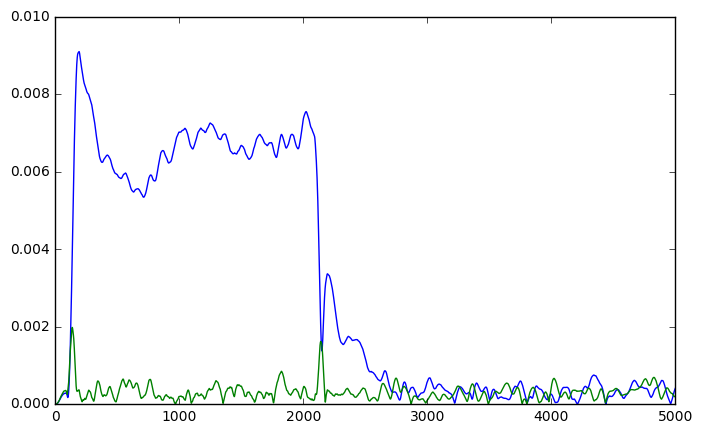

In [48]:
# as with basic...
# nb: index1 is actually the list demodulation frequency index but setpoints are ind of broken
data4 = qc.Measure(samp_acq_controller.acquisition).run()
plot = qc.MatPlot(data4.samp_acq_controller_magnitude[0])
plot.add(data4.samp_acq_controller_magnitude[1])
plot.fig

In [35]:
data4.samp_acq_controller_magnitude[0]

array([  3.59998900e-07,   7.23784543e-07,   1.81824540e-06, ...,
         3.18445386e-04,   3.15040241e-04,   3.14722229e-04])

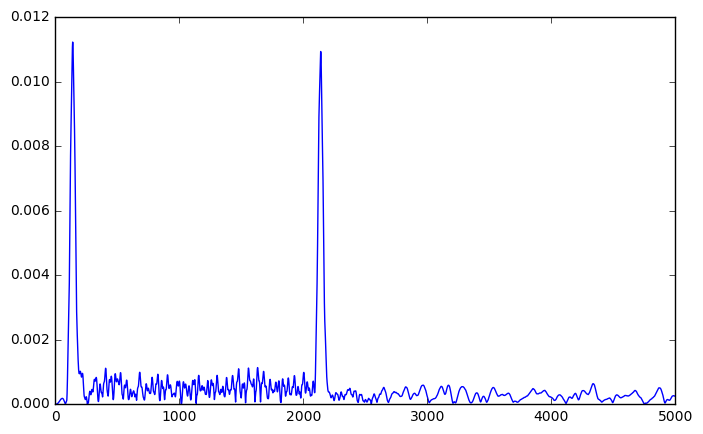

In [45]:
qc.MatPlot(data4.samp_acq_controller_magnitude[1]).fig

In [30]:
# in a loop

data5 = qc.Loop(samp_acq_controller.demod_freq_0.sweep(1e6, 21e6, 2e6)).each(
    samp_acq_controller.acquisition).run(name='AlazarTest')

DataSet:
   mode     = DataMode.LOCAL
   location = '2017-01-23/15-55-55_AlazarTest'
   <Type>   | <array_id>                           | <array.name> | <array.shape>
   Setpoint | samp_acq_controller_demod_freq_0_set | demod_freq_0 | (11,)
   Measured | index1                               | index1       | (11, 1, 3000)
   Measured | samp_acq_controller_magnitude        | magnitude    | (11, 1, 3000)
   Measured | samp_acq_controller_phase            | phase        | (11, 1, 3000)
started at 2017-01-23 15:56:04


In [33]:
# plotting the measured demodulated amplitude (samples on y axis, different freqs on x), only looking at the one we swept
qc.QtPlot(data5.samp_acq_controller_magnitude[:, 0])

ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

### Averaged Acquisition

As above but averages over the samples to give one magnitude per demodulation frequency

In [4]:
ave_controller = ave_controller.HD_Averaging_Controller(name='ave_controller', 
                                             alazar_name='Alazar', 
                                             demod_length = 8)

In [5]:
# set the  demodulation frequencies
samp_acq_controller.demod_freq_0(1e6)
samp_acq_controller.demod_freq_1(2e6)
samp_acq_controller.demod_freq_2(3e6)
samp_acq_controller.demod_freq_3(4e6)
samp_acq_controller.demod_freq_4(5e6)
samp_acq_controller.demod_freq_5(6e6)
samp_acq_controller.demod_freq_6(7e6)
samp_acq_controller.demod_freq_7(8e6)


# This command is specific to this acquisition controller. The kwargs provided here are being forwarded to ats_inst.acquire
# This way, it becomes easy to change acquisition specific settings from the ipython notebook
ave_controller.update_acquisition_kwargs(#mode='NPT',
                 records_per_buffer=1,
                 buffers_per_acquisition=1,
                 allocated_buffers=1,
)

# set integration time and delay (nb this replaces need to set samples_per record)
# if int_delay is unset it will default to a value corresponding to the about needed for the filter to work well
ave_controller.int_time(2e-6)
ave_controller.int_delay(0)

In [6]:
ave_controller.acquisition.acquisition_kwargs

{'allocated_buffers': 1,
 'buffers_per_acquisition': 1,
 'records_per_buffer': 1,
 'samples_per_record': 1024}

DataSet:
   mode     = DataMode.LOCAL
   location = '2017-01-23/10-51-30'
   <Type>   | <array_id>               | <array.name> | <array.shape>
   Measured | index0                   | index0       | (8,)
   Measured | ave_controller_magnitude | magnitude    | (8,)
   Measured | ave_controller_phase     | phase        | (8,)
acquired at 2017-01-23 10:51:31


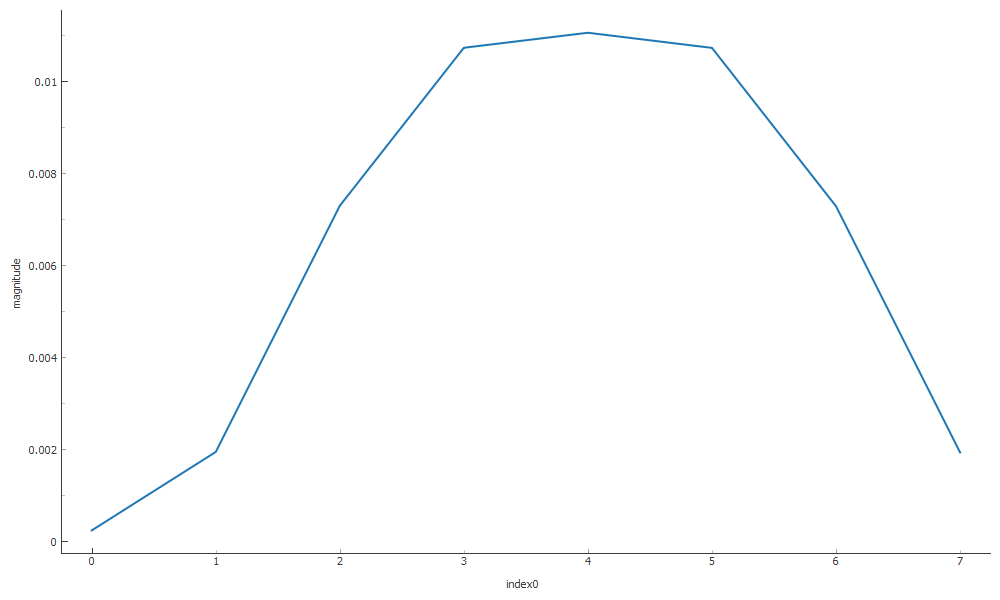

In [7]:
# as with basic...
# nb: index1 is actually the list demodulation frequency index but setpoints are ind of broken
data6 = qc.Measure(ave_controller.acquisition).run()
qc.QtPlot(data6.ave_controller_magnitude)

### Records Acquisition

As above but doesnt average over records so is useful with seq mode on

In [ ]:
# Configure settings on Alazar card for sequencing mode (ie use aux i/o for triggering as well)
ats_inst.config(aux_io_mode='AUX_IN_TRIGGER_ENABLE', 
                aux_io_param='TRIG_SLOPE_POSITIVE')

In [8]:
rec_controller = record_controller.HD_Records_Controller(name='rec_controller', 
                                                    alazar_name='Alazar', 
                                                    demod_length = 4)
rec_controller.demod_freq_0(1e6)
rec_controller.demod_freq_1(4e6)
rec_controller.demod_freq_2(8e6)
rec_controller.demod_freq_3(12e6)

In [12]:
# This command is specific to this acquisition controller. The kwargs provided here are being forwarded to 
# ats_inst.acquire. This way, it becomes easy to change acquisition specific settings from the ipython notebook
rec_controller.update_acquisition_kwargs(#mode='NPT',
                 buffers_per_acquisition=100,
                 allocated_buffers=1,
)

# records_num a parameter of the records acq controller which is mainly a move towards having the 
# setpoints in the record direction be settable by the user and also to make it easier to write wrapper functions
# which change it when there is an AWG upload, (replaces need to set records_per_buffer)
rec_controller.record_num(20)

# set integration time and delay (nb this replaces need to set samples_per record)
# if int_delay is unset it will default to a value corresponding to the about needed for the filter to work well
rec_controller.int_time(2e-6)
rec_controller.int_delay.to_default()

DataSet:
   mode     = DataMode.LOCAL
   location = '2017-01-23/10-58-35'
   <Type>   | <array_id>               | <array.name> | <array.shape>
   Measured | index1                   | index1       | (4, 20)
   Measured | rec_controller_magnitude | magnitude    | (4, 20)
   Measured | rec_controller_phase     | phase        | (4, 20)
acquired at 2017-01-23 10:58:36


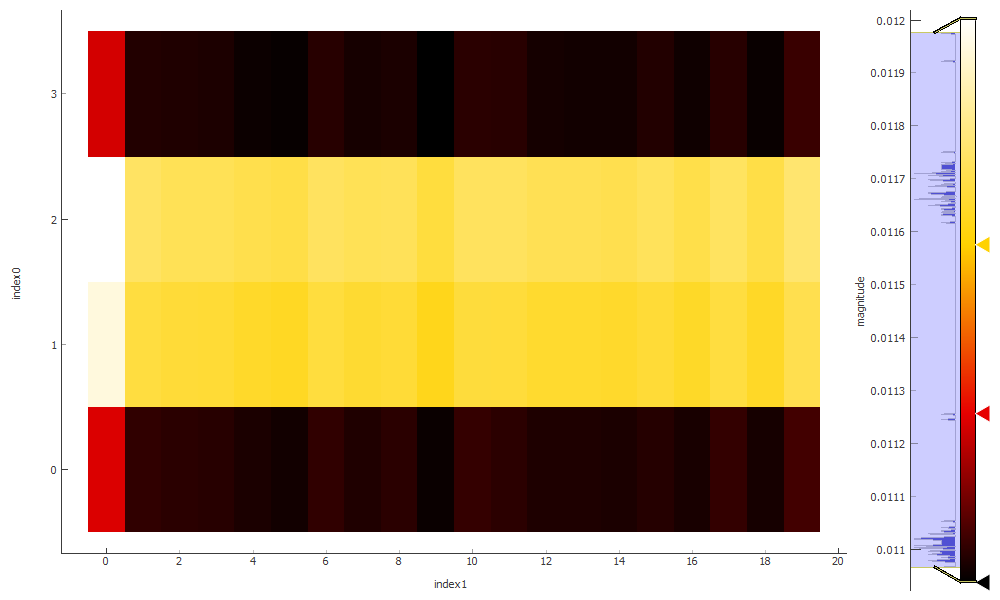

In [19]:
data7 = qc.Measure(rec_controller.acquisition).run()
qc.QtPlot(data7.rec_controller_magnitude)